In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([-0.04578213,  0.02354491,  0.03440884, -0.01564381], dtype=float32)

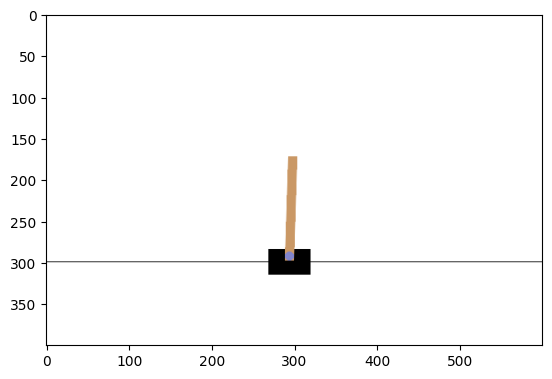

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch

#定义模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
    torch.nn.Softmax(dim=1),
)

model_td = sequential = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),
)

model(torch.randn(2, 4)), model_td(torch.randn(2, 4))

(tensor([[0.3646, 0.6354],
         [0.4279, 0.5721]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.2427],
         [0.1591]], grad_fn=<AddmmBackward0>))

In [4]:
import random


#得到一个动作
def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 4)
    #[1, 4] -> [1, 2]
    prob = model(state)

    #根据概率选择一个动作
    action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]

    return action


get_action([1, 2, 3, 4])

0

In [5]:
def get_data():
    states = []
    rewards = []
    actions = []
    next_states = []
    overs = []

    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        next_state, reward, over, _ = env.step(action)

        #记录数据样本
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        next_states.append(next_state)
        overs.append(over)

        #更新游戏状态,开始下一个动作
        state = next_state

    #[b, 4]
    states = torch.FloatTensor(states).reshape(-1, 4)
    #[b, 1]
    rewards = torch.FloatTensor(rewards).reshape(-1, 1)
    #[b, 1]
    actions = torch.LongTensor(actions).reshape(-1, 1)
    #[b, 4]
    next_states = torch.FloatTensor(next_states).reshape(-1, 4)
    #[b, 1]
    overs = torch.LongTensor(overs).reshape(-1, 1)

    return states, rewards, actions, next_states, overs


get_data()

/tmp/ipykernel_1740/2726165283.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  states = torch.FloatTensor(states).reshape(-1, 4)


(tensor([[-8.6252e-03,  2.4674e-02,  4.0613e-02,  7.5287e-04],
         [-8.1317e-03,  2.1919e-01,  4.0628e-02, -2.7884e-01],
         [-3.7479e-03,  4.1371e-01,  3.5051e-02, -5.5844e-01],
         [ 4.5263e-03,  2.1811e-01,  2.3882e-02, -2.5493e-01],
         [ 8.8886e-03,  4.1289e-01,  1.8784e-02, -5.3998e-01],
         [ 1.7146e-02,  2.1751e-01,  7.9843e-03, -2.4144e-01],
         [ 2.1496e-02,  2.2271e-02,  3.1555e-03,  5.3752e-02],
         [ 2.1942e-02, -1.7290e-01,  4.2305e-03,  3.4743e-01],
         [ 1.8484e-02,  2.2166e-02,  1.1179e-02,  5.6083e-02],
         [ 1.8927e-02,  2.1713e-01,  1.2301e-02, -2.3305e-01],
         [ 2.3270e-02,  4.1207e-01,  7.6397e-03, -5.2183e-01],
         [ 3.1511e-02,  2.1684e-01, -2.7969e-03, -2.2675e-01],
         [ 3.5848e-02,  4.1200e-01, -7.3319e-03, -5.2031e-01],
         [ 4.4088e-02,  2.1698e-01, -1.7738e-02, -2.2995e-01],
         [ 4.8428e-02,  4.1236e-01, -2.2337e-02, -5.2817e-01],
         [ 5.6675e-02,  6.0778e-01, -3.2901e-02, -8.278

In [6]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step(action)
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

16.0

In [7]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    optimizer_td = torch.optim.Adam(model_td.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    #玩N局游戏,每局游戏训练一次
    for i in range(1000):
        #玩一局游戏,得到数据
        #states -> [b, 4]
        #rewards -> [b, 1]
        #actions -> [b, 1]
        #next_states -> [b, 4]
        #overs -> [b, 1]
        states, rewards, actions, next_states, overs = get_data()

        #计算values和targets
        #[b, 4] -> [b ,1]
        values = model_td(states)

        #[b, 4] -> [b ,1]
        targets = model_td(next_states) * 0.98
        #[b ,1] * [b ,1] -> [b ,1]
        targets *= (1 - overs)
        #[b ,1] + [b ,1] -> [b ,1]
        targets += rewards

        #时序差分误差
        #[b ,1] - [b ,1] -> [b ,1]
        delta = (targets - values).detach()

        #重新计算对应动作的概率
        #[b, 4] -> [b ,2]
        probs = model(states)
        #[b ,2] -> [b ,1]
        probs = probs.gather(dim=1, index=actions)

        #根据策略梯度算法的导函数实现
        #只是把公式中的reward_sum替换为了时序差分的误差
        #[b ,1] * [b ,1] -> [b ,1] -> scala
        loss = (-probs.log() * delta).mean()

        #时序差分的loss就是简单的value和target求mse loss即可
        loss_td = loss_fn(values, targets.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        optimizer_td.zero_grad()
        loss_td.backward()
        optimizer_td.step()

        if i % 100 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(i, test_result)


train()

0 29.7
100 26.8
200 56.2
300 71.7
400 165.7
500 194.8
600 192.3
700 196.3
800 200.0
900 200.0


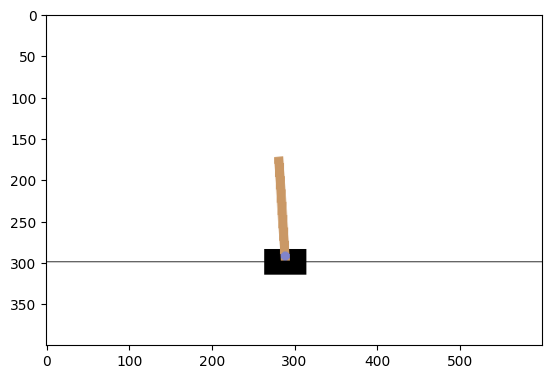

200.0

In [8]:
test(play=True)